In [1]:
#import packages and check GPU availablity 
import torch
import torchvision
import torchvision.transforms as transforms
#from google.colab import drive
from torchvision.transforms.autoaugment import TrivialAugmentWide
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [8]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 2.70G/2.70G [00:14<00:00, 196MB/s]
100% 2.70G/2.70G [00:14<00:00, 194MB/s]


In [ ]:
! unzip new-plant-diseases-dataset.zip

In [12]:
! mv "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" "/content/dataset"

In [4]:
#global variable and training param
torch.cuda.empty_cache()
epoch = 30
batch_size = 4
lr = 0.005
momentum = 0.9
gamma = 0.1
step_size = 4375

In [5]:
#load training and testing data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#trainset = torchvision.datasets.ImageFolder('tomatoLeaf-3/train/images',transform = transform)
trainset = torchvision.datasets.ImageFolder('./New Plant Diseases Dataset(Augmented)/train',transform = transform)

print(len(trainset))




trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#testset = torchvision.datasets.ImageFolder('tomatoLeaf-3/valid/images',transform = transform)
testset = torchvision.datasets.ImageFolder('./New Plant Diseases Dataset(Augmented)/valid',transform = transform)
print(len(testset))
#testset,validset = random_split(testset,[2585,2000])
testset,validset = random_split(testset,[10000,7572])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

validloader = torch.utils.data.DataLoader(validset,batch_size = batch_size,
                                          shuffle = True, num_workers = 2)
classes = []
for name in os.listdir("./New Plant Diseases Dataset(Augmented)/train"):
#for name in os.listdir("./drive/MyDrive/Colab Notebooks/train/tomato"):
  classes.append(name)


FileNotFoundError: [WinError 3] The system cannot find the path specified: './New Plant Diseases Dataset(Augmented)/train'

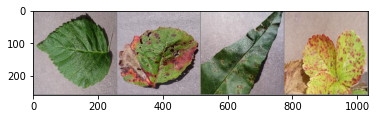

Potato___Early_blight Apple___Black_rot Corn_(maize)___Northern_Leaf_Blight Apple___Black_rot


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [16]:
#create model and define optimizer and scheduler 

net = torchvision.models.alexnet()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma = gamma,step_size=step_size, verbose = True)



Adjusting learning rate of group 0 to 5.0000e-03.


In [17]:
for each in range(epoch):  # loop over the dataset multiple times
    print("epoch ", each)
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    valid_loss = 0.0
    net.eval()
    for i, data in enumerate(validloader,0):
      inputs.labels = data[0].to(device),data[1].to(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      valid_loss += loss

    scheduler.step()
    print(f' train loss: {running_loss / len(trainloader)}, valid loss: {valid_loss / len(validloader)}')
    running_loss = 0.0       

print('Finished Training')
print("...")
torch.save(net.state_dict(), '/content/drive/MyDrive/cifar_net.pth')
print("Training saved")

epoch  0


RuntimeError: ignored

In [ ]:
#load model 
net = torchvision.models.alexnet()
net.load_state_dict(torch.load('/content/drive/MyDrive/cifar_net.pth'))
net.to(device)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')